# Integrase EDA

In [121]:
import numpy as np
import pandas as pd
import torch

from Bio.Seq import Seq

from scipy import stats
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error,mean_poisson_deviance,mean_gamma_deviance, explained_variance_score, max_error, mean_squared_log_error, median_absolute_error
import matplotlib.pyplot as plt

import pickle

In [2]:
data_dir = "/data/rajan/integrase"
emb_dir = f"{data_dir}/emb"
esm2_3B_emb_dir = f"{emb_dir}/esm2_3B"
ORF_emb_dir = f"{esm2_3B_emb_dir}/ORF"
seq_emb_dir = f"{esm2_3B_emb_dir}/seqs"
attB_emb_dir = f"{esm2_3B_emb_dir}/attB"
attP_emb_dir = f"{esm2_3B_emb_dir}/attP"
fasta_dir = f"{data_dir}/fasta"

In [3]:
data = pd.read_excel(f"{data_dir}/integrase_w_efficiency.xlsx", sheet_name="Helper")

In [4]:
data.head()

,#,Int Name,Efficiency,ATTB,ATTP,ORF
0,1,Int1,8.454545,ggaactccgccgggcccatctggtcgaagaagatgaaggggcccac...,atggggtcacaataccaatcatgttcaagaatgtgaagggtatttt...,ATGACCAACCCCGCCTCCAGACCTAAGGCCTACAGCTACATCAGAA...
1,2,Int2,29.568182,ggacggcgcagaaggggagtagctcttcgccggaccgtcgacatac...,gctcatgtatgtgtctacgcgagattctcgcccgagaacttctgca...,ATGCCTATCGCCCCTGAGTTCCTGTCTCTGGCTTATCCTGGACAGG...
2,3,Int3,14.636364,gtttgtaaaggagactgataatggcatgtacaactatactcgtcgg...,atggataaaaaaatacagcgtttttcatgtacaactatactagttg...,ATGCGGAAGGTGGCCATCTATAGCCGGGTGTCTACAATTAACCAAG...
3,4,Int4,31.500000,ttccaaagagcgcccaacgcgacctgaaatttgaataagactgctg...,caaaaattacaaagttttcaacccttgatttgaattagcggtcaaa...,ATGATCACAACCAGGAAGGTGGCCATCTACGTGCGGGTGTCCACCA...
4,5,Int5,14.568182,gagcgccggatcagggagtggacggcctgggagcgctacacgctgt...,ccctaatacgcaagtcgataactctcctgggagcgttgacaacttg...,ATGCCAGGGATGACCACAGAAACCGGACCTGACCCAGCCGGACTTA...


In [5]:
# Convert DNA protein-coding ORFs to protein ORFs

data['seq'] = data.ORF.apply(lambda x: str(Seq(x).translate()).replace('*',''))


/home/rajan/miniconda3/envs/proteins/lib/python3.8/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [6]:
data

,#,Int Name,Efficiency,ATTB,ATTP,ORF,seq
0,1,Int1,8.454545,ggaactccgccgggcccatctggtcgaagaagatgaaggggcccac...,atggggtcacaataccaatcatgttcaagaatgtgaagggtatttt...,ATGACCAACCCCGCCTCCAGACCTAAGGCCTACAGCTACATCAGAA...,MTNPASRPKAYSYIRMSSAIQIKGDSFRRQAEASAKYAAEHDLDLI...
1,2,Int2,29.568182,ggacggcgcagaaggggagtagctcttcgccggaccgtcgacatac...,gctcatgtatgtgtctacgcgagattctcgcccgagaacttctgca...,ATGCCTATCGCCCCTGAGTTCCTGTCTCTGGCTTATCCTGGACAGG...,MPIAPEFLSLAYPGQEFPAYLYGRASRDPKRKGRSVQSQLDEGRAT...
2,3,Int3,14.636364,gtttgtaaaggagactgataatggcatgtacaactatactcgtcgg...,atggataaaaaaatacagcgtttttcatgtacaactatactagttg...,ATGCGGAAGGTGGCCATCTATAGCCGGGTGTCTACAATTAACCAAG...,MRKVAIYSRVSTINQAEEGYSIQGQIEALTKYCEAMEWKIYKNYSD...
3,4,Int4,31.500000,ttccaaagagcgcccaacgcgacctgaaatttgaataagactgctg...,caaaaattacaaagttttcaacccttgatttgaattagcggtcaaa...,ATGATCACAACCAGGAAGGTGGCCATCTACGTGCGGGTGTCCACCA...,MITTRKVAIYVRVSTTNQAEEGYSIQGQIDSLIKYCEAMGWIIYEE...
4,5,Int5,14.568182,gagcgccggatcagggagtggacggcctgggagcgctacacgctgt...,ccctaatacgcaagtcgataactctcctgggagcgttgacaacttg...,ATGCCAGGGATGACCACAGAAACCGGACCTGACCCAGCCGGACTTA...,MPGMTTETGPDPAGLIDLFCRKSKAVKSRANGAGQRRKQEISIAAQ...
...,...,...,...,...,...,...,...
194,195,Meta12,7.405000,GACGGGAAACTGAAAATGTGTTCACAGGTTGCTCCGGGCTATGAAA...,TATGCAGTCTATTTTTTAGACTAAATGCATTGTAATACATTGATAT...,ATGGGAAGAAGGCGAAGTCATGAGCGCCGGGATTTACCCCCTAACC...,MGRRRSHERRDLPPNLYIRNNGYYCYRDPRTGKEFGLGRDRRIAIT...
195,196,Meta13,40.050000,TATTAGTTTTAAAAAATGTATATTTTTTGTTTTTGTATATTAGATA...,AAAACAGCCTCCTGCAAATGTGGCGATTTCTTTTTTTTCAGACATA...,ATGACCAAACCAATTGAAAAGAATATGCTCAGATCTCGAGCAATAA...,MTKPIEKNMLRSRAIKLPEVTESMWEQVDEEHRNLVQEFLDAHSFR...
196,197,Meta15,8.395000,ATTAGCGGGTATACTCATGCCGCATTGTCCTCTTAGTTAAATGGAT...,TGAGGCATTTTCATTTATCAAGATATCCAGACCTACCATCGCCGCA...,ATGCTCACCGTTAAGCAGATTGAAGCAGCAAAGCCGAAAGAAAAAC...,MLTVKQIEAAKPKEKPYRLLDGNGLYLYVPVSGKKVWQLRYKIDGK...
197,198,Meta16,8.535000,GAGAAAGTCGCGTCCTGCGCCAGTACGTTCTTAGCCATCTGACCAA...,TCATATGAACTCGCTACGGCGGGTTTTGTTTTATGGAGTGAATGAT...,ATGTCACTATTCCGCAGAGGTGAAACCTGGTACTCCAGTTTCACAT...,MSLFRRGETWYSSFTLPNGKRFKQSLGTKDKRQATELHDKLKAEAW...


In [7]:
# unlabeled_data = pd.read_excel(f"{data_dir}/integrase_unlabeled.xlsx")
# unlabeled_data.head()

1. Create fasta files for attB, attP and ORFs with "int name" as seq id
2. Create embeddings
3. Linear regression - recombinant or not recombinant
4. Intrinisic dimension: https://huggingface.co/blog/AmelieSchreiber/intrinsic-dimension-of-proteins
5. Random Forest


In [8]:
save_fasta = False
if save_fasta:
    # Seqs
    with open(f'{fasta_dir}/int_w_eff_seqs.fasta', 'w') as f:
        for int_name, seq in zip(data['Int Name'], data['seq']):
            f.write(f'>{int_name}\n{seq.upper()}\n')
    # # ORF 
    # with open(f'{fasta_dir}/int_w_eff_ORF.fasta', 'w') as f:
    #     for int_name, ORF_str in zip(data['Int Name'], data['ORF']):
    #         f.write(f'>{int_name}\n{ORF_str.upper()}\n')
    # # attB
    # with open(f'{fasta_dir}/int_w_eff_attB.fasta', 'w') as f:
    #     for int_name, attB in zip(data['Int Name'], data['ATTB']):
    #         f.write(f'>{int_name}\n{attB.upper()}\n')
    # # attP
    # with open(f'{fasta_dir}/int_w_eff_attP.fasta', 'w') as f:
    #     for int_name, attP in zip(data['Int Name'], data['ATTP']):
    #         f.write(f'>{int_name}\n{attP.upper()}\n')

In [9]:
!ls {esm2_3B_emb_dir}

ORF  attB  attP  seqs


In [10]:
# A118_emb = torch.load(f"{esm2_3B_emb_dir}/A118.pt")

In [11]:
# A118_emb["representations"][36].size()

In [12]:
# A118_emb["mean_representations"][36].size()

In [13]:
# add mean emb to df
data['seq_mean_emb'] = [ torch.load(f"{seq_emb_dir}/{int_name.strip()}.pt")["mean_representations"][36].numpy()
                         for int_name in data["Int Name"].tolist() ]

# data['ORF_mean_emb'] = [ torch.load(f"{ORF_emb_dir}/{int_name.strip()}.pt")["mean_representations"][36].numpy()
#                          for int_name in data["Int Name"].tolist() ]

# data['attB_mean_emb'] = [ torch.load(f"{attB_emb_dir}/{int_name.strip()}.pt")["mean_representations"][36].numpy()
#                          for int_name in data["Int Name"].tolist() ]

# data['attP_mean_emb'] = [ torch.load(f"{attP_emb_dir}/{int_name.strip()}.pt")["mean_representations"][36].numpy()
#                          for int_name in data["Int Name"].tolist() ]

In [14]:
data.head()

,#,Int Name,Efficiency,ATTB,ATTP,ORF,seq,seq_mean_emb
0,1,Int1,8.454545,ggaactccgccgggcccatctggtcgaagaagatgaaggggcccac...,atggggtcacaataccaatcatgttcaagaatgtgaagggtatttt...,ATGACCAACCCCGCCTCCAGACCTAAGGCCTACAGCTACATCAGAA...,MTNPASRPKAYSYIRMSSAIQIKGDSFRRQAEASAKYAAEHDLDLI...,"[-0.012143803, -0.0052933423, -0.0072857062, 0..."
1,2,Int2,29.568182,ggacggcgcagaaggggagtagctcttcgccggaccgtcgacatac...,gctcatgtatgtgtctacgcgagattctcgcccgagaacttctgca...,ATGCCTATCGCCCCTGAGTTCCTGTCTCTGGCTTATCCTGGACAGG...,MPIAPEFLSLAYPGQEFPAYLYGRASRDPKRKGRSVQSQLDEGRAT...,"[0.018540306, -0.026513908, -0.039321538, 0.02..."
2,3,Int3,14.636364,gtttgtaaaggagactgataatggcatgtacaactatactcgtcgg...,atggataaaaaaatacagcgtttttcatgtacaactatactagttg...,ATGCGGAAGGTGGCCATCTATAGCCGGGTGTCTACAATTAACCAAG...,MRKVAIYSRVSTINQAEEGYSIQGQIEALTKYCEAMEWKIYKNYSD...,"[-0.018123832, -0.008340224, -0.046946924, 0.0..."
3,4,Int4,31.500000,ttccaaagagcgcccaacgcgacctgaaatttgaataagactgctg...,caaaaattacaaagttttcaacccttgatttgaattagcggtcaaa...,ATGATCACAACCAGGAAGGTGGCCATCTACGTGCGGGTGTCCACCA...,MITTRKVAIYVRVSTTNQAEEGYSIQGQIDSLIKYCEAMGWIIYEE...,"[-0.0050011743, -0.0090518985, -0.056376845, 0..."
4,5,Int5,14.568182,gagcgccggatcagggagtggacggcctgggagcgctacacgctgt...,ccctaatacgcaagtcgataactctcctgggagcgttgacaacttg...,ATGCCAGGGATGACCACAGAAACCGGACCTGACCCAGCCGGACTTA...,MPGMTTETGPDPAGLIDLFCRKSKAVKSRANGAGQRRKQEISIAAQ...,"[0.02901023, -0.012837757, -0.04548945, 0.0252..."


<Axes: ylabel='Frequency'>

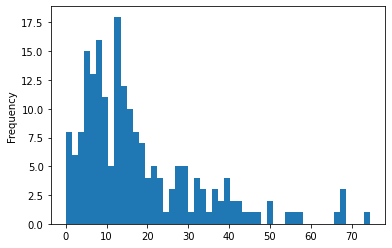

In [15]:
data.Efficiency.plot.hist(bins=50)

In [16]:
def plot_hist(vals, label):
    plt.hist(vals, bins=50, label=label)
    plt.legend()
    plt.show()

#### Log transformation

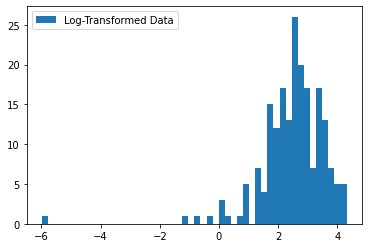

In [17]:
log_eff = np.log(data.Efficiency)
# data["log_eff"] = log_eff
plt.hist(log_eff, bins=50, label='Log-Transformed Data')
plt.legend()
plt.show()

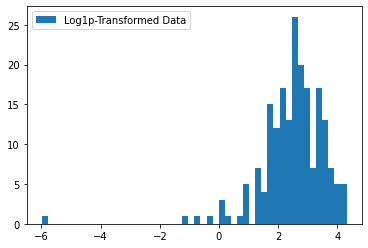

In [18]:
log1p_eff = np.log1p(data.Efficiency)
# data["log1p_eff"] = log1p_eff
plt.hist(log_eff, bins=50, label='Log1p-Transformed Data')
plt.legend()
plt.show()

#### Square Root Transformation

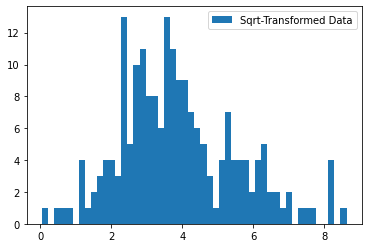

(0.050362323579871054, 8.634234187233979)

In [19]:
sqrrt_target = data.Efficiency**(1/2)
data["sqrt_eff"] = sqrrt_target
plot_hist(sqrrt_target, "Sqrt-Transformed Data")
min(sqrrt_target), max(sqrrt_target)

In [20]:
eff_df = pd.DataFrame(data.Efficiency)
eff_df["sqrt_eff"] = sqrrt_target
eff_df["inv_sqrt_eff"] = sqrrt_target**2
eff_df

,Efficiency,sqrt_eff,inv_sqrt_eff
0,8.454545,2.907670,8.454545
1,29.568182,5.437663,29.568182
2,14.636364,3.825750,14.636364
3,31.500000,5.612486,31.500000
4,14.568182,3.816829,14.568182
...,...,...,...
194,7.405000,2.721213,7.405000
195,40.050000,6.328507,40.050000
196,8.395000,2.897413,8.395000
197,8.535000,2.921472,8.535000


#### Box-cox Transformation

In [21]:
from scipy.stats import boxcox
bcx_target, lam = boxcox(data.Efficiency)
print(lam)

0.322672854665954


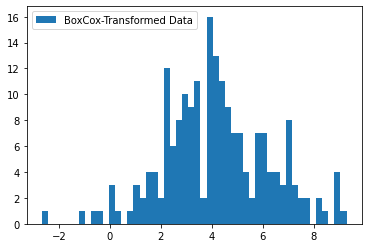

In [22]:
from scipy.special import boxcox, inv_boxcox

bcx_target = boxcox(data.Efficiency, 0.32)
# data["bcx_eff"] = bcx_target

plt.hist(bcx_target, bins=50, label='BoxCox-Transformed Data')
plt.legend()
plt.show()

In [23]:
inv_boxcox(bcx_target, 0.32)

0       8.454545
1      29.568182
2      14.636364
3      31.500000
4      14.568182
         ...    
194     7.405000
195    40.050000
196     8.395000
197     8.535000
198    38.800000
Name: Efficiency, Length: 199, dtype: float64

#### Yeo-Johnson Transformation

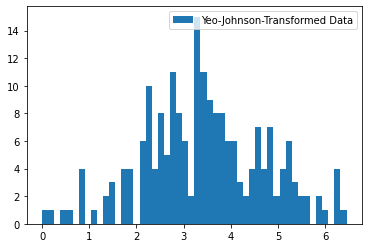

In [24]:
from scipy.stats import yeojohnson

yj_target, lam = yeojohnson(data.Efficiency)
# data["yj_eff"] = yj_target
plt.hist(yj_target, bins=50, label='Yeo-Johnson-Transformed Data')
plt.legend()
plt.show()

In [25]:
pt_yj_w_std = PowerTransformer(method='yeo-johnson', standardize=True)
pt_yj_w_std.fit(data.Efficiency.values.reshape(-1, 1))
print(pt_yj_w_std.lambdas_)

yj_w_std_eff = pt_yj_w_std.transform(data.Efficiency.values.reshape(-1, 1))
# data["bcx_eff"] = yj_w_std_eff

print(min(yj_w_std_eff), max(yj_w_std_eff))

inv_yj_w_std_eff = pt_yj_w_std.inverse_transform(yj_w_std_eff)

[0.17400427]
[-2.69139755] [2.36003515]


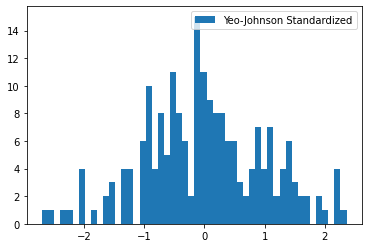

In [26]:
plt.hist(yj_w_std_eff, bins=50, label='Yeo-Johnson Standardized')
plt.legend()
plt.show()

In [27]:
pt_yj_wo_std = PowerTransformer(method='yeo-johnson', standardize=False)
pt_yj_wo_std.fit(data.Efficiency.values.reshape(-1, 1))
print(pt_yj_wo_std.lambdas_)

yj_wo_std_eff = pt_yj_wo_std.transform(data.Efficiency.values.reshape(-1, 1))
data["yj_eff"] = yj_wo_std_eff
# yj_wo_std_eff

print(min(yj_wo_std_eff), max(yj_wo_std_eff))

inv_yj_wo_std_eff = pt_yj_wo_std.inverse_transform(yj_wo_std_eff)
# inv_yj_wo_std_eff

[0.17400427]
[0.00253371] [6.45023616]


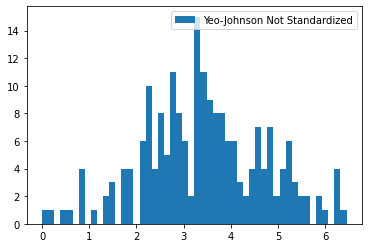

In [28]:
# Use this!
plt.hist(data["yj_eff"], bins=50, label='Yeo-Johnson Not Standardized')
plt.legend()
plt.show()

In [29]:
eff_df = pd.DataFrame(data.Efficiency)
eff_df["yj_eff"] = yj_wo_std_eff
eff_df["inv_yj_eff"] = inv_yj_wo_std_eff
eff_df

,Efficiency,yj_eff,inv_yj_eff
0,8.454545,2.748843,8.454545
1,29.568182,4.673390,29.568182
2,14.636364,3.526112,14.636364
3,31.500000,4.785097,31.500000
4,14.568182,3.519063,14.568182
...,...,...,...
194,7.405000,2.576661,7.405000
195,40.050000,5.221925,40.050000
196,8.395000,2.739508,8.395000
197,8.535000,2.761379,8.535000


In [30]:
pt_bcx = PowerTransformer(method='box-cox', standardize=True)

pt_bcx.fit(data.Efficiency.values.reshape(-1, 1))
print(pt_bcx.lambdas_)

bcx_tran_eff = pt_bcx.transform(data.Efficiency.values.reshape(-1, 1))
# data["bcx_eff"] = bcx_tran_eff
# bcx_tran_eff

print(min(bcx_tran_eff), max(bcx_tran_eff))

inv_bcx_tran_eff = pt_bcx.inverse_transform(bcx_tran_eff)
# inv_bcx_tran_eff

[0.32267285]
[-3.30291361] [2.49884764]


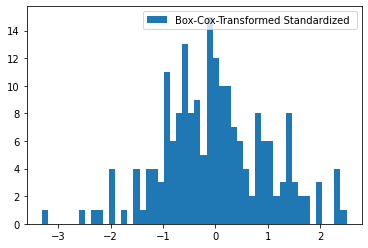

In [31]:
plt.hist(bcx_tran_eff, bins=50, label='Box-Cox-Transformed Standardized ')
plt.legend()
plt.show()

In [32]:
pt_bcx = PowerTransformer(method='box-cox', standardize=False)

pt_bcx.fit(data.Efficiency.values.reshape(-1, 1))
print(pt_bcx.lambdas_)

bcx_tran_eff = pt_bcx.transform(data.Efficiency.values.reshape(-1, 1))
data["bcx_eff"] = bcx_tran_eff
# bcx_tran_eff

print(min(bcx_tran_eff), max(bcx_tran_eff))

inv_bcx_tran_eff = pt_bcx.inverse_transform(bcx_tran_eff)
# inv_bcx_tran_eff

[0.32267285]
[-2.6486636] [9.35823387]


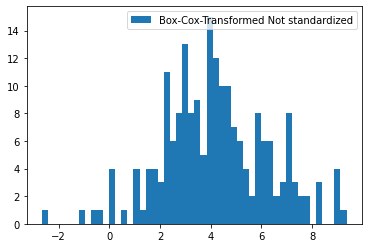

In [33]:
plt.hist(bcx_tran_eff, bins=50, label='Box-Cox-Transformed Not standardized')
plt.legend()
plt.show()

<Axes: ylabel='Frequency'>

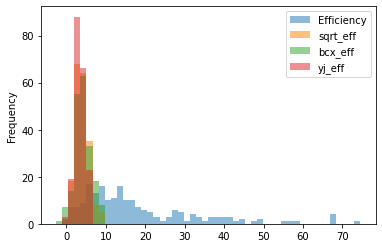

In [34]:
data[["Efficiency", "sqrt_eff", "bcx_eff", "yj_eff"]].plot.hist(bins=50, alpha=0.5) # others: "log_eff", "log1p_eff",

In [35]:
min(data.yj_eff), max(data.yj_eff)

(0.0025337108574162485, 6.450236164033601)

In [36]:
pickle.dump(data, open('/home/rajan/integrase/data.pkl', 'wb'))

### Train-test split

In [64]:
X = data[["seq_mean_emb"]] #, "attB_mean_emb", "attP_mean_emb"]]
X

,seq_mean_emb
0,"[-0.012143803, -0.0052933423, -0.0072857062, 0..."
1,"[0.018540306, -0.026513908, -0.039321538, 0.02..."
2,"[-0.018123832, -0.008340224, -0.046946924, 0.0..."
3,"[-0.0050011743, -0.0090518985, -0.056376845, 0..."
4,"[0.02901023, -0.012837757, -0.04548945, 0.0252..."
...,...
194,"[-0.01841487, -0.04296414, 0.025662318, -0.005..."
195,"[-0.016178748, -0.019424891, 0.0032140228, -0...."
196,"[0.00045493752, -0.074196965, -0.010153705, -0..."
197,"[-0.0089121, -0.072285675, 0.024879273, -0.002..."


In [65]:
#yeo-johnson transformed efficiency
y = data.yj_eff

# # sqrt transformed efficiency
# y = data.sqrt_eff

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
X_train.head()

,seq_mean_emb
183,"[0.0007259564, -0.0017953799, -0.008699755, 0...."
38,"[0.018937012, -6.393679e-05, -0.03457202, 0.04..."
24,"[-0.04628304, 0.021061413, 0.010323375, 0.0269..."
142,"[-0.006698824, -0.0015498165, -0.015730834, 0...."
141,"[-0.00032132873, -0.040824797, -0.015657645, 0..."


In [123]:
def display_metrics(y_true, y_pred, label):
    print('**',label,'**')
    print('Mean Absolute Error (MAE):', mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', mean_squared_error(y_true, y_pred))
    print('Root Mean Squared Error (RMSE):', mean_squared_error(y_true, y_pred, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_true, y_pred))
    print('Explained Variance Score:', explained_variance_score(y_true, y_pred))
    print('Max Error:', max_error(y_true, y_pred))
    print('Mean Squared Log Error:', mean_squared_log_error(y_true, y_pred))
    print('Median Absolute Error:', median_absolute_error(y_true, y_pred))
    print('R^2:', r2_score(y_true, y_pred))
    print('Mean Poisson Deviance:', mean_poisson_deviance(y_true, y_pred))
    print('Mean Gamma Deviance:', mean_gamma_deviance(y_true, y_pred))

### Linear Regression

In [68]:
# Concatenating the arrays (ORF, attB, attP) in X_train and stacking them vertically
# X_train_flat = np.vstack([np.concatenate(arr) for arr in X_train.to_numpy()])

X_train_vals = np.vstack(X_train['seq_mean_emb'])

# Converting y_train to a NumPy array
y_train_vals = y_train.to_numpy()

In [69]:
# Concatenating the arrays in X_test and stacking them vertically
# X_test_flat = np.vstack([np.concatenate(arr) for arr in X_test.to_numpy()])

X_test_vals = np.vstack(X_test['seq_mean_emb'])

# Converting y_train to a NumPy array
y_test_vals = y_test.to_numpy()

In [70]:
model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5)


In [71]:
model.fit(X_train_vals, y_train_vals)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1], cv=5)

In [72]:
#r2
model.score(X_train_vals, y_train_vals)

0.36934440918897027

In [73]:
#r2
model.score(X_test_vals, y_test_vals)

-0.21344572155268215

In [74]:
y_hat_train = model.predict(X_train_vals)
y_hat_test = model.predict(X_test_vals)

In [75]:
# # inverse sqrt transformation
# inv_y_train = y_train_vals**2
# inv_y_test = y_test_vals**2

# inv_y_hat_train = y_hat_train**2
# inv_y_hat_test = y_hat_test**2

In [76]:
# #inverse yeo-johnshon transformation
inv_y_train = pt_yj_wo_std.inverse_transform(y_train_vals.reshape(-1, 1))
inv_y_test = pt_yj_wo_std.inverse_transform(y_test_vals.reshape(-1, 1))

inv_y_hat_train = pt_yj_wo_std.inverse_transform(y_hat_train.reshape(-1, 1))
inv_y_hat_test = pt_yj_wo_std.inverse_transform(y_hat_test.reshape(-1, 1))

In [77]:
print('Train r2 score:', r2_score(inv_y_train, inv_y_hat_train))
print('Test r2 score:', r2_score(inv_y_test, inv_y_hat_test))

Train r2 score: 0.2510100798688547
Test r2 score: -0.1784139351816909


In [78]:
print('MAE train:', mean_absolute_error(inv_y_train, inv_y_hat_train))
print('MAE test:', mean_absolute_error(inv_y_test, inv_y_hat_test))

MAE train: 8.68987220423345
MAE test: 10.154962888977739


In [79]:
print('MSE train:', mean_squared_error(inv_y_train, inv_y_hat_train))
print('MSE test:', mean_squared_error(inv_y_test, inv_y_hat_test))

MSE train: 163.37129277494935
MSE test: 266.5653982385223


In [80]:
train_corr = stats.spearmanr(inv_y_train, inv_y_hat_train)[0]
train_corr


0.6752190018280332

In [81]:
test_corr = stats.spearmanr(inv_y_hat_test, inv_y_test)[0]
test_corr

0.14108818011257038

In [82]:
min(inv_y_train), max(inv_y_train)

(array([0.00253636]), array([68.]))

In [83]:
min(inv_y_test), max(inv_y_test)

(array([3.47]), array([74.55]))

In [125]:
display_metrics(inv_y_train, inv_y_hat_train, 'RidgeCV-train')
display_metrics(inv_y_test, inv_y_hat_test, 'RidgeCV-test')

** RidgeCV-train **
Mean Absolute Error (MAE): 8.68987220423345
Mean Squared Error (MSE): 163.37129277494935
Root Mean Squared Error (RMSE): 12.78167801092444
Mean Absolute Percentage Error (MAPE): 12.400631541649073
Explained Variance Score: 0.31185030033439
Max Error: 47.934507751464835
Mean Squared Log Error: 0.47078953622750946
Median Absolute Error: 5.729262525385074
R^2: 0.2510100798688547
Mean Poisson Deviance: 7.556577001486898
Mean Gamma Deviance: 0.610982412165799
** RidgeCV-test **
Mean Absolute Error (MAE): 10.154962888977739
Mean Squared Error (MSE): 266.5653982385223
Root Mean Squared Error (RMSE): 16.32683062442072
Mean Absolute Percentage Error (MAPE): 0.580961511771033
Explained Variance Score: -0.022833635616564818
Max Error: 64.18130378723136
Mean Squared Log Error: 0.5105187146975614
Median Absolute Error: 5.102809689261699
R^2: -0.1784139351816909
Mean Poisson Deviance: 13.274678185985376
Mean Gamma Deviance: 0.824924904722496


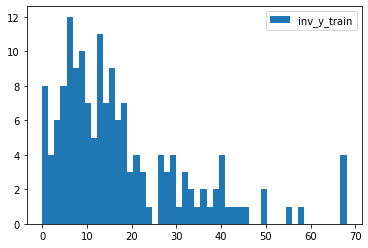

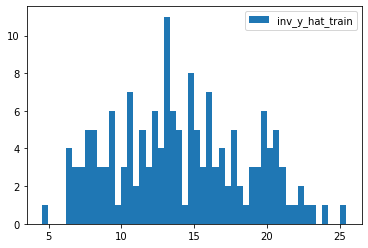

In [84]:
plot_hist(inv_y_train, 'inv_y_train')
plot_hist(inv_y_hat_train, 'inv_y_hat_train')

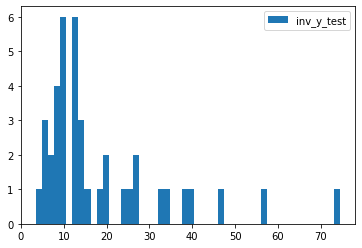

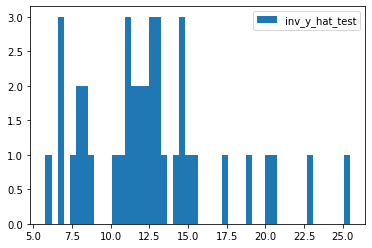

In [85]:
plot_hist(inv_y_test, 'inv_y_test')
plot_hist(inv_y_hat_test, 'inv_y_hat_test')

In [86]:
def plot_true_v_pred(true, pred, title):
    plt.figure(figsize=(10,10))
    plt.scatter(true, pred, c='crimson')
    p1 = max(max(pred), max(true))
    p2 = min(min(pred), min(true))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True efficiency', fontsize=15)
    plt.ylabel('Predicted efficiency', fontsize=15)
    plt.axis('equal')
    plt.title(title, fontsize=15)
    plt.show()

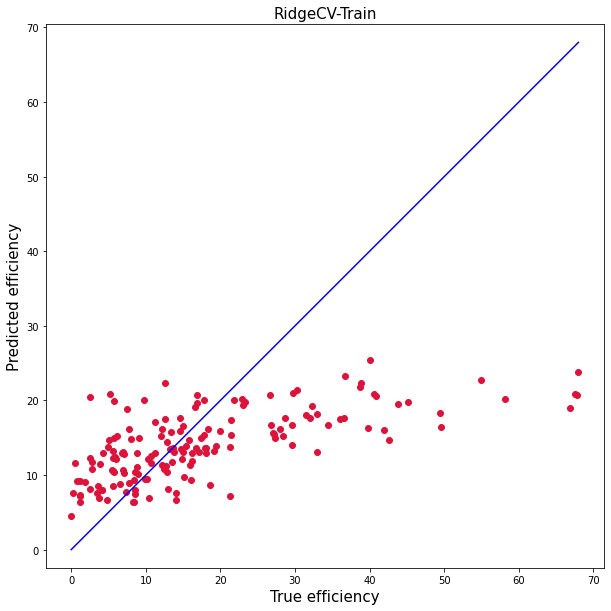

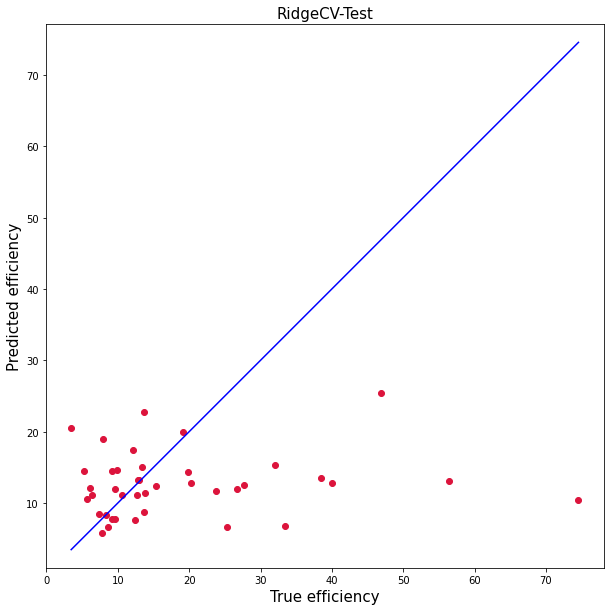

In [87]:
plot_true_v_pred(inv_y_train, inv_y_hat_train, "RidgeCV-Train")
plot_true_v_pred(inv_y_test, inv_y_hat_test, "RidgeCV-Test")

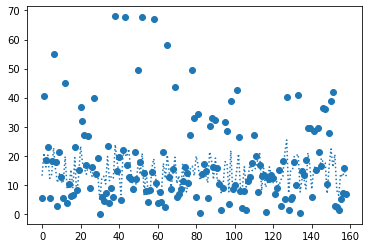

In [88]:
x = []
plt.plot(inv_y_hat_train, linestyle = 'dotted')
for i in range(0,len(inv_y_train)):
    x.append(i)
plt.scatter(x, inv_y_train)
plt.show()

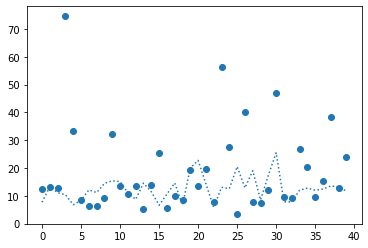

In [89]:
x = []
plt.plot(inv_y_hat_test, linestyle = 'dotted')
for i in range(0,len(inv_y_test)):
    x.append(i)
plt.scatter(x, inv_y_test)
plt.show()

In [90]:
model.get_params()

{'alpha_per_target': False,
 'alphas': [0.001, 0.01, 0.1, 1],
 'cv': 5,
 'fit_intercept': True,
 'gcv_mode': None,
 'scoring': None,
 'store_cv_values': False}

In [91]:
# def plotGraph(y_actual, y_pred, regressorName):
#     plt.figure(figsize=(10,10))
#     p1 = max(max(y_pred), max(y_actual))
#     p2 = min(min(y_pred), min(y_actual))
#     plt.plot([p1, p2], [p1, p2], 'g-')
#     plt.scatter(range(len(y_actual)), y_actual, color='blue')
#     plt.scatter(range(len(y_pred)), y_pred, color='red')
#     plt.xlabel('True efficiency', fontsize=15)
#     plt.ylabel('Predicted efficiency', fontsize=15)
#     plt.title(regressorName)
#     plt.show()
#     return


In [92]:
len(y_train)

159

In [93]:
len(y_train)

159

In [94]:
results_train = pd.DataFrame({'y_train': y_train, 'y_hat_train': y_hat_train})
results_train.sort_values(by=["y_train"], ascending=False)

,y_train,y_hat_train
165,6.259273,4.303541
185,6.251692,4.075518
193,6.247133,4.081279
32,6.225747,3.928981
117,5.940037,4.033079
...,...,...
43,0.833801,2.562160
131,0.565539,2.864212
150,0.405723,3.184186
191,0.260368,2.598893


In [95]:
# plotGraph(y_train, y_hat_train, "Train - RidgeCV")

In [96]:
# plotGraph(y_test, y_hat_test, "Test - RidgeCV")

In [97]:
results_test = pd.DataFrame({'inv_y_test': inv_y_test.reshape([40]), 'inv_y_hat_test': inv_y_hat_test.reshape([40])})
results_test.head()

,inv_y_test,inv_y_hat_test
0,12.363636,7.677033
1,12.977273,13.244042
2,12.659091,11.121104
3,74.550000,10.368696
4,33.440909,6.786418


### Decision Tree

In [98]:
X_train_vals = np.vstack(X_train['seq_mean_emb'])
y_train_vals = y_train.to_numpy()

X_test_vals = np.vstack(X_test['seq_mean_emb'])
y_test_vals = y_test.to_numpy()

In [99]:
tree_mod = DecisionTreeRegressor(random_state=42)

In [100]:
tree_mod.fit(X_train_vals, y_train_vals)

DecisionTreeRegressor(random_state=42)

In [101]:
tree_scores = cross_val_score(tree_mod, X_train_vals, y_train_vals, cv=5)
tree_scores

array([-1.22383696, -0.25590517, -0.72680583, -1.25033554, -0.71228602])

In [102]:
tree_scores = cross_val_score(tree_mod, X_train_vals, y_train_vals**2, cv=5)
tree_scores
np.mean(tree_scores)

-1.446914515453075

In [103]:
print(f"mean cross validation score: {np.mean(tree_scores)}")
print(f"r2score without cv: {tree_mod.score(X_train_vals, y_train_vals)}")

mean cross validation score: -1.446914515453075
r2score without cv: 0.9515156654680812


In [104]:
y_hat_train_wo_tuning = tree_mod.predict(X_train_vals)
y_hat_test_wo_tuning = tree_mod.predict(X_test_vals)


In [105]:
print(r2_score(y_test, y_hat_test_wo_tuning))

-0.3905426444310709


In [129]:
g_cv = GridSearchCV(
    tree_mod,
    param_grid={
        'max_depth': [5, 8, 10],
        'min_samples_split': [2, 5, 7],
        "min_samples_leaf":[3,5,7,9],
    },
    cv=5,
    scoring='r2'
  )

In [130]:
g_cv.fit(X_train_vals, y_train_vals)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [5, 8, 10],
                         'min_samples_leaf': [3, 5, 7, 9],
                         'min_samples_split': [2, 5, 7]},
             scoring='r2')

In [131]:
g_cv.best_params_

{'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [132]:
g_cv.best_score_

-0.5510597278761158

In [133]:
tuned_tree_mod = DecisionTreeRegressor(**g_cv.best_params_)
tuned_tree_mod.fit(X_train_vals, y_train_vals)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=9)

In [134]:
tuned_tree_mod.score(X_train_vals, y_train_vals)

0.6452798748819267

In [135]:
y_hat_train = tuned_tree_mod.predict(X_train_vals)
y_hat_test = tuned_tree_mod.predict(X_test_vals)

In [136]:
# #inverse yeo-johnshon transformation
inv_y_train = pt_yj_wo_std.inverse_transform(y_train_vals.reshape(-1, 1))
inv_y_test = pt_yj_wo_std.inverse_transform(y_test_vals.reshape(-1, 1))

inv_y_hat_train = pt_yj_wo_std.inverse_transform(y_hat_train.reshape(-1, 1))
inv_y_hat_test = pt_yj_wo_std.inverse_transform(y_hat_test.reshape(-1, 1))

In [137]:
display_metrics(inv_y_train, inv_y_hat_train, 'DecisionTree-train')
display_metrics(inv_y_test, inv_y_hat_test, 'DecisionTree-test')

** DecisionTree-train **
Mean Absolute Error (MAE): 6.817666278562615
Mean Squared Error (MSE): 100.38996984057746
Root Mean Squared Error (RMSE): 10.019479519444983
Mean Absolute Percentage Error (MAPE): 5.5136536035086285
Explained Variance Score: 0.55199626239136
Max Error: 31.646873625208777
Mean Squared Log Error: 0.2549858028563432
Median Absolute Error: 4.215115713559827
R^2: 0.5397534400585238
Mean Poisson Deviance: 4.411530924566808
Mean Gamma Deviance: 0.40129675635521933
** DecisionTree-test **
Mean Absolute Error (MAE): 13.954525520473945
Mean Squared Error (MSE): 372.1808174626137
Root Mean Squared Error (RMSE): 19.29198842687331
Mean Absolute Percentage Error (MAPE): 0.9727641853221536
Explained Variance Score: -0.610147742496745
Max Error: 68.82885566141456
Mean Squared Log Error: 0.8888956489827734
Median Absolute Error: 8.715909090909086
R^2: -0.6453112992287686
Mean Poisson Deviance: 19.848255391352218
Mean Gamma Deviance: 1.5806517272170644


In [138]:
print(r2_score(y_test, y_hat_test))

-1.0173467844512567


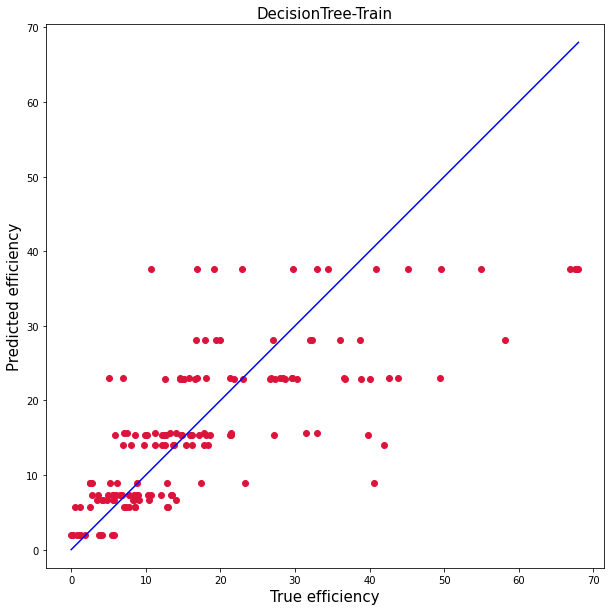

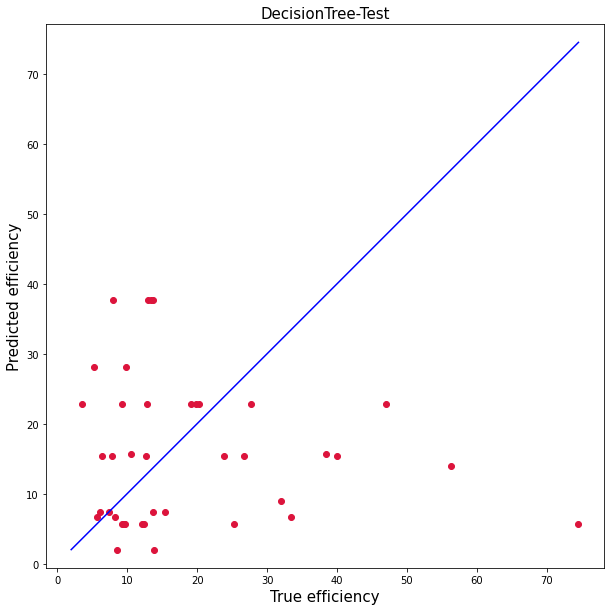

In [139]:
plot_true_v_pred(inv_y_train, inv_y_hat_train, 'DecisionTree-Train')
plot_true_v_pred(inv_y_test, inv_y_hat_test, 'DecisionTree-Test')


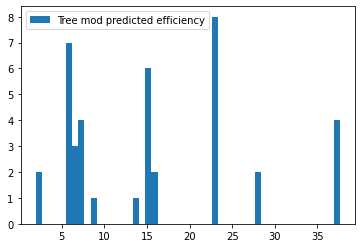

In [140]:
plt.hist(inv_y_hat_test, bins=50, label='Tree mod predicted efficiency')
plt.legend()
plt.show()

In [141]:
# not tuned
print('MAE:', mean_absolute_error(y_test,y_hat_test_wo_tuning))
print('MSE:', mean_squared_error(y_test, y_hat_test_wo_tuning))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat_test_wo_tuning)))

MAE: 0.8981155313380785
MSE: 1.6201652430652551
RMSE: 1.272857118087201


In [142]:
# tuned
print('MAE:', mean_absolute_error(y_test,y_hat_test))
print('MSE:', mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat_test)))

MAE: 1.2521948941296226
MSE: 2.350474583765559
RMSE: 1.5331257560179332


In [143]:
from scipy.special import inv_boxcox
eff = inv_boxcox(y_test, 0.32)
pred_eff = inv_boxcox(y_hat_test, 0.32)

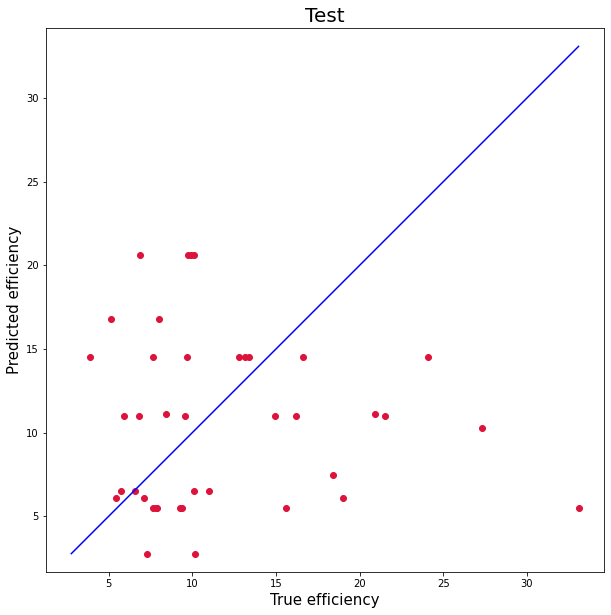

In [144]:
plt.figure(figsize=(10,10))
plt.scatter(eff, pred_eff, c='crimson')

p1 = max(max(pred_eff), max(eff))
p2 = min(min(pred_eff), min(eff))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True efficiency', fontsize=15)
plt.ylabel('Predicted efficiency', fontsize=15)
plt.axis('equal')
plt.title("Test", fontsize=20)
plt.show()